# **Goal: Use LLMs For Code-Generation** 💻

In this webinar, the goal is to use an LLM for code generation. The model will take natural language as input, and should return code as output. We're first going to iterate on a base Llama-2-7b model with prompting, and finally instruction-fine-tune the model.

As an example, if we prompt the model with this instruction:

```
Instruction: Create an array of length 5 which contains all even numbers between 1 and 10.
```

We want the model to produce exactly this response:

```
Response: array = [2, 4, 6, 8, 10]
```



# **A Quick 2 Minute Introduction To Ludwig** ⏰

Every Ludwig model is based on a config, which requires at least input feature and one output feature to be defined. For example,

```yaml
input_features:
  - name: instruction
    type: text
output_features:
  - name: output
    type: text
```

is a simple Ludwig config that tells Ludwig to use the column called `instruction` in our dataset as an input feature and the `output` column in our dataset as an `output` feature. This is the simplest Ludwig config we can define - it's just 6 lines and works out of the box!

To make Ludwig compatible with LLMs, **Ludwig 0.8** introduced a new `model_type` called `llm` and a new keyword `base_model` that must be specified:

```yaml
model_type: llm
base_model: meta-llama/Llama-2-7b-hf
input_features:
  - name: instruction
    type: text
output_features:
  - name: output
    type: text
```

The `model_type` parameter indicates is used to tell Ludwig you want to use the LLM model type (Ludwig supports LLMs, general deep neural networks and trees).
The `base_model` parameter is the path to any HuggingFace CausalLM listed [here](https://huggingface.co/models?pipeline_tag=text-generation&sort=trending).

Once you define your YAML Config, there are two ways you can use it with Ludwig:

- Through the Python LudwigModel API: https://ludwig.ai/latest/user_guide/api/LudwigModel/
- Through the Ludwig CLI: https://ludwig.ai/latest/user_guide/command_line_interface/

For this webinar, we're going to make use of the Python LudwigModel API. This requires just one main object during initialization: a YAML config defining your training pipeline. The initialized LudwigModel object then exposes a variety of methods like `preprocess()`, `train()`, `evaluate()` and `predict()`. We will see this in practice in the next few sections.

In general, there is feature parity across both methods so you can use the approach you're most comfortable with. To see what commands are available, create a new cell and run `!ludwig --help`.

This is all you need for now! Keeping this in mind, let's dive into the latest features in Ludwig 0.8.

## **Basic Setup** 🧰

We're going to install Ludwig, setup our HuggingFace Token and load our dataset that we will be running experiments with.

### **Install Ludwig and Ludwig's LLM related dependencies.**

Install Ludwig from the latest release

In [ ]:
# !pip install ludwig
# !pip install ludwig[llm]

Install Ludwig from Ludwig master

In [1]:
!pip uninstall -y tensorflow --quiet
!pip install git+https://github.com/ludwig-ai/ludwig.git@master --quiet
!pip install "git+https://github.com/ludwig-ai/ludwig.git@master#egg=ludwig[llm]" --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 10.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━

Enable text wrapping so we don't have to scroll horizontally and create a function to flush CUDA cache.

In [2]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    model = None
    torch.cuda.empty_cache()

### **Setup Your HuggingFace Token** 🤗

We'll be exploring Llama-2 today, which a model released by Meta. However, the model is not openly-accessible and requires requesting for access (assigned to your HuggingFace token).

Obtain a [HuggingFace API Token](https://huggingface.co/settings/tokens) and request access to [Llama2-7b-hf](https://huggingface.co/meta-llama/Llama-2-7b-hf) before proceeding. You may need to signup on HuggingFace if you don't aleady have an account: https://huggingface.co/join

Incase you haven't been given access to Llama-2-7b, that is alright. We can just use Llama-1 for the rest of this example: [huggyllama/llama-7b](https://huggingface.co/huggyllama/llama-7b).

In [3]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


### **Import The Code Generation Dataset** 📋



In [4]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

df = pd.read_json("https://raw.githubusercontent.com/sahil280114/codealpaca/master/data/code_alpaca_20k.json")

# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)

# For this webinar, we will just 100 rows of this dataset.
df = df.head(n=100)

## **Understanding The Code Alpaca Dataset** 📖




In [5]:
df.head(10)

,instruction,input,output,split
0,Create an array of length 5 which contains all...,,"arr = [2, 4, 6, 8, 10]",0
1,Formulate an equation to calculate the height ...,,Height of triangle = opposite side length * si...,0
2,Write a replace method for a string class whic...,"string = ""Hello World!""\nreplace_with = ""Greet...","def replace(self, replace_with):\n new_stri...",0
3,Create an array of length 15 containing number...,,"arr = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33...",0
4,Write a function to find the number of distinc...,"matrix = [[1, 0, 0],\n [1, 0, 1],\n ...",def find_num_distinct_states(matrix):\n sta...,0
5,Create a nested loop to print every combinatio...,,for i in range(10):\n for j in range(10):\n...,0
6,Write a function to find the maximum differenc...,"arr = [5, 3, 17, 11, 9]",def max_difference(arr):\n max_diff = 0\n ...,0
7,Write a function to generate the nth Fibonacci...,< noinput >,def fib(n):\n if n == 0:\n return 0\...,0
8,Write a class to represent a 2D point with x a...,,"class Point:\n def __init__(self, x, y):\n ...",0
9,Write code that removes spaces from a given st...,"string = "" A B C D ""","def remove_spaces(string): \n return """".joi...",0


This dataset is meant to train a large language model to following instructions to produce code from natural language. Each row in the dataset consists of an:
- `instruction` that describes a task
- `input` when additional context is required for the instruction, and
- the expected `output`.

There are two types of instructions:

#### **Type 1: Self-Sufficient**
Instructions that are self-sufficient and require no additional context.
```
Instruction: "Create an array of length 5 which contains all even numbers between 1 and 10."
Input: None (instruction is self-sufficient)
Output: "arr = [2, 4, 6, 8, 10]"
```

These examples are useful for training models to understand and follow instructions independently. They can be applied in various scenarios, including:

- **Coding Tasks**: Teaching a model to generate code based on a clear instruction. For instance, generating a function to sort an array in a specific way.
- **Mathematical Calculations**: Instructing a model to perform calculations or equations, such as finding the area of a shape given its dimensions.
- **Data Manipulation**: Showing how to process data, like filtering, transforming, or aggregating data based on given criteria.
- **Writing Instructions**: Training models to generate instructional content, like recipes, guides, or tutorials.

#### **Type 2: Need Context**
The instruction needs additional context provided in the `input` to complete the task.
```
Instruction: "Write a replace method for a string class which replaces the given string with a given set of characters."
Input: "string = 'Hello World!' replace_with = 'Greetings!'"
Output:
def replace(string, replace_with):
    new_string = ""
    for char in string:
        if char == " ":
            new_string += replace_with
        else:
            new_string += char
    return new_string
```

These examples are useful for training models to understand both the instruction and relevant context provided by the input. They find application in scenarios such as:

- **Customized Code Generation**: Teaching a model to generate code that depends on specific inputs. For instance, creating a function to calculate a mathematical result given input parameters.
- **Conditional Responses**: Guiding models to produce outputs that change based on different input conditions (think of a instruction that has different criteria for different letter grades, and then a conditional input like score = 85/100)
- **Dynamic Content Creation**: Training models to generate content based on variable input, such as dynamic forms, letters, or responses to user queries.
- **Configurable Processes**: Demonstrating how to perform tasks with customizable settings, like configuring a software component using provided parameters.


As you can see below, the dataset is pretty balanced in terms of the number of examples of each type of instruction (also true for the full dataset with 20,000 rows).

In [6]:
num_self_sufficient = (df['input'] == '').sum()
num_need_contex = df.shape[0] - num_self_sufficient

# We are only using 100 rows of this dataset for this webinar
print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"% of examples that are self-sufficient: {round(num_self_sufficient/df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_contex/df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 100
% of examples that are self-sufficient: 49.0
% of examples that are need additional context: 51.0


The other aspect worth noting is the average number of characters in each of the three columns `instruction`, `input` and `output` in the dataset. Typically, every 3-4 characters maps to a *token* (the basic building blocks that language models use to understand and analyze text data), and large language models have a limit on the number of tokens they can take as input.

The maximum context length for the base LLaMA-2 model is 4096 tokens. Ludwig automatically truncates texts that are too long for the model, but looking at these sequence lengths, we should be able to fine-tune on full length examples without needing any truncation.





Average number of tokens in the instruction column: 23
Average number of tokens in the input column: 8
Average number of tokens in the output column: 65



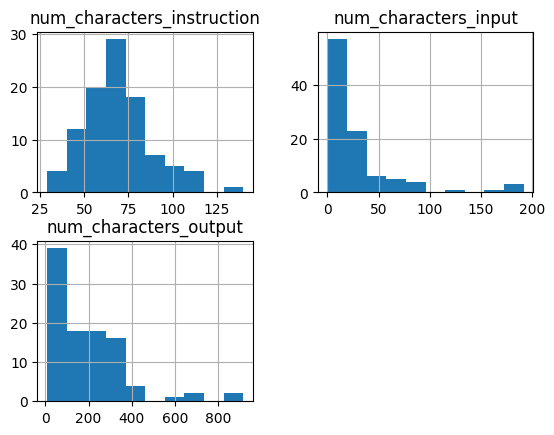

In [7]:
# Calculating the length of each cell in each column
df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_input'] = df['input'].apply(lambda x: len(x))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

# **Declaratively Fine-Tune Large Language Models**

Fine-tuning a large language model **refers to the process of further training the pre-trained model on a specific task or domain using a smaller dataset.** The initial pre-training phase involves training a language model on a massive corpus of text data to learn general language patterns and representations. Fine-tuning, on the other hand, customizes the model to a specific task or domain by exposing it to task-specific data. By fine-tuning a large language model on a specific task, you leverage the pre-trained knowledge of the model while tailoring it to the nuances and requirements of your target task. This typically allows the model to perform better and achieve higher accuracy on the specific task compared to using the pretrained model by itself for your specific task.

#### ▶ **What is instruction following/tuning? Why should I do it?**

Pre-trained language models are often great at giving general answers, but they struggle when asked to follow specific instructions, especially for tasks in certain domains. To make a pre-trained model do better at these specific tasks, we can train it on examples of those tasks. This is called instruction fine-tuning. We use a dataset with pairs of `{instructions, outputs}` in the domain, and this helps the model learn to give the right response when given those types of instructions. This training process typically changes the underlying model weights, but there are also other ways to train it without doing this. When done correctly, this process teaches the model to understand and follow instructions it couldn't handle well before.

#### ▶ **What will this teach the model?**

Here's an example of prompting the base model and an example prompting the fine-tuned model. The model was given all of the text until `Response:`, and it was supposed to continue generating an appropriate response.

**Using the base model (no fine-tuning):** 👎
```
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: create an array of length 5 which contains all even numbers between 1 and 10.

### Response:\n\n### Instruction: create an array of length 5 which contains all even numbers between 1 and 10.\n\n### Input: \n\n### Response:\n\n### Instruction: create an array of length 5 which contains all even numbers between 1 and 10.\n\n### Input: \n\n### Response:\n\n### Instruction: create an array of length 5 which contains all even numbers between 1 and 10.\n\n### Input: \n\n### Response:\n\n### Instruction: create an
```

**After instruction-fine-tuning:** 👍
```
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: create an array of length 5 which contains all even numbers between 1 and 10.

### Response: array = [2, 4, 6, 8, 10]
```

The base model does not know how to follow-instructions and answer the question for our task, so just repeats the inputs we passed in until the token limit is hit. Our fine-tuned model should be able to respond back correctly (these are actual outputs from a model we fine-tuned).


There are three different fine-tuning approaches in Ludwig:

1. **Full Fine-Tuning**:

- Involves training the entire pre-trained model on new data from scratch.
- All model layers and parameters are updated during fine-tuning.
- Can lead to high accuracy but requires a significant amount of computational resources and time.
- Runs the risk of catastrophic forgetting: occasionally, since we are updating all of the weights in the model, this process can lead to the algorithm inadvertently losing knowledge of its past tasks, i.e., the knowledge it gained during pretraining. The outcome may vary, with the algorithm experiencing heightened error margins in some cases, while in others, it might completely erase the memory of a specific task leading to terrible performance.
- Best suited when the target task is significantly different from the original pre-training task.

2. **Parameter Efficient Fine-Tuning (PEFT), e.g. LoRA**:

- Focuses on updating only a subset of the model's parameters.
- Often involves freezing certain layers or parts of the model to avoid catastrophic forgetting, or inserting additional layers that are trainable while keeping the original model's weights frozen.
- Can result in faster fine-tuning with fewer computational resources, but might sacrifice some accuracy compared to full fine-tuning.
- Includes methods like LoRA, AdaLoRA and Adaption Prompt (LLaMA Adapter)
- Suitable when the new task shares similarities with the original pre-training task.

3. **Quantization-Based Fine-Tuning (QLoRA)**:

- Involves reducing the precision of model parameters (e.g., converting 32-bit floating-point values to 8-bit or 4-bit integers). This reduces the amount of CPU and GPU memory required by either 4x if using 8-bit integers, or 8x if using 4-bit integers.
- Typically, since we're changing the weights to 8 or 4 bit integers, we will lose some precision/performance.
- This can lead to reduced memory usage and faster inference on hardware with reduced precision support.
- Particularly useful when deploying models on resource-constrained devices, such as mobile phones or edge devices.


**Today, we're going to fine-tune using method 3 since we only have access to a single T4 GPU with 16GiB of GPU VRAM on Colab.** If you have more compute available, give LoRA based fine-tuning or full fine-tuning a try! Typically this requires 4 GPUs with 24GiB of GPU VRAM on a single node multi-GPU cluster and fine-tuning Deepspeeed.


To do this, the new parameters we're introducing are:

- `adapter`: The PEFT method we want to use
- `quantization`: Load the weights in int4 or int8 to reduce memory overhead.
- `trainer`: We enable the `finetune` trainer and can configure a variety of training parameters such as epochs and learning rate.

In [9]:
clear_cache()

qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: meta-llama/Llama-2-7b-hf

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

trainer:
  type: finetune
  epochs: 5
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.00001
  optimizer:
    type: adam
    params:
      eps: 1.e-8
      betas:
        - 0.9
        - 0.999
      weight_decay: 0
  learning_rate_scheduler:
    decay: cosine
    warmup_fraction: 0.03
    reduce_on_plateau: 0
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_0                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.util

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 350 step(s), approximately 5 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 350 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:   0%|          | 0/350 [00:00<?, ?it/s]

INFO:ludwig.trainers.trainer:Train loss for step 0: 0.043


Training:   0%|          | 1/350 [00:00<05:06,  1.14it/s]

INFO:ludwig.trainers.trainer:Train loss for step 1: 0.050


Training:   1%|          | 2/350 [00:01<04:42,  1.23it/s]

INFO:ludwig.trainers.trainer:Train loss for step 2: 0.135


Training:   1%|          | 3/350 [00:02<03:56,  1.47it/s]

INFO:ludwig.trainers.trainer:Train loss for step 3: 0.111


Training:   1%|          | 4/350 [00:02<03:42,  1.56it/s]

INFO:ludwig.trainers.trainer:Train loss for step 4: 0.076


Training:   1%|▏         | 5/350 [00:03<03:32,  1.62it/s]

INFO:ludwig.trainers.trainer:Train loss for step 5: 0.092


Training:   2%|▏         | 6/350 [00:03<03:25,  1.67it/s]

INFO:ludwig.trainers.trainer:Train loss for step 6: 0.038


Training:   2%|▏         | 7/350 [00:04<04:16,  1.34it/s]

INFO:ludwig.trainers.trainer:Train loss for step 7: 0.072


Training:   2%|▏         | 8/350 [00:05<03:56,  1.45it/s]

INFO:ludwig.trainers.trainer:Train loss for step 8: 0.042


Training:   3%|▎         | 9/350 [00:06<04:13,  1.34it/s]

INFO:ludwig.trainers.trainer:Train loss for step 9: 0.079


Training:   3%|▎         | 10/350 [00:06<03:54,  1.45it/s]

INFO:ludwig.trainers.trainer:Train loss for step 10: 0.135


Training:   3%|▎         | 11/350 [00:07<03:41,  1.53it/s]

INFO:ludwig.trainers.trainer:Train loss for step 11: 0.125


Training:   3%|▎         | 12/350 [00:08<03:30,  1.61it/s]

INFO:ludwig.trainers.trainer:Train loss for step 12: 0.100


Training:   4%|▎         | 13/350 [00:08<03:22,  1.66it/s]

INFO:ludwig.trainers.trainer:Train loss for step 13: 0.105


Training:   4%|▍         | 14/350 [00:09<03:31,  1.59it/s]

INFO:ludwig.trainers.trainer:Train loss for step 14: 0.133


Training:   4%|▍         | 15/350 [00:09<03:23,  1.65it/s]

INFO:ludwig.trainers.trainer:Train loss for step 15: 0.059


Training:   5%|▍         | 16/350 [00:11<04:38,  1.20it/s]

INFO:ludwig.trainers.trainer:Train loss for step 16: 0.048


Training:   5%|▍         | 17/350 [00:11<04:29,  1.24it/s]

INFO:ludwig.trainers.trainer:Train loss for step 17: 0.117


Training:   5%|▌         | 18/350 [00:12<04:05,  1.35it/s]

INFO:ludwig.trainers.trainer:Train loss for step 18: 0.073


Training:   5%|▌         | 19/350 [00:13<04:33,  1.21it/s]

INFO:ludwig.trainers.trainer:Train loss for step 19: 0.066


Training:   6%|▌         | 20/350 [00:14<04:19,  1.27it/s]

INFO:ludwig.trainers.trainer:Train loss for step 20: 0.072


Training:   6%|▌         | 21/350 [00:14<04:09,  1.32it/s]

INFO:ludwig.trainers.trainer:Train loss for step 21: 0.093


Training:   6%|▋         | 22/350 [00:15<03:52,  1.41it/s]

INFO:ludwig.trainers.trainer:Train loss for step 22: 0.068


Training:   7%|▋         | 23/350 [00:16<03:39,  1.49it/s]

INFO:ludwig.trainers.trainer:Train loss for step 23: 0.185


Training:   7%|▋         | 24/350 [00:16<03:27,  1.57it/s]

INFO:ludwig.trainers.trainer:Train loss for step 24: 0.047


Training:   7%|▋         | 25/350 [00:17<03:40,  1.48it/s]

INFO:ludwig.trainers.trainer:Train loss for step 25: 0.108


Training:   7%|▋         | 26/350 [00:18<03:31,  1.53it/s]

INFO:ludwig.trainers.trainer:Train loss for step 26: 0.188


Training:   8%|▊         | 27/350 [00:18<03:20,  1.61it/s]

INFO:ludwig.trainers.trainer:Train loss for step 27: 0.053


Training:   8%|▊         | 28/350 [00:19<03:31,  1.52it/s]

INFO:ludwig.trainers.trainer:Train loss for step 28: 0.083


Training:   8%|▊         | 29/350 [00:20<03:37,  1.48it/s]

INFO:ludwig.trainers.trainer:Train loss for step 29: 0.130


Training:   9%|▊         | 30/350 [00:20<03:27,  1.54it/s]

INFO:ludwig.trainers.trainer:Train loss for step 30: 0.057


Training:   9%|▉         | 31/350 [00:21<03:35,  1.48it/s]

INFO:ludwig.trainers.trainer:Train loss for step 31: 0.058


Training:   9%|▉         | 32/350 [00:25<08:32,  1.61s/it]

INFO:ludwig.trainers.trainer:Train loss for step 32: 0.056


Training:   9%|▉         | 33/350 [00:26<07:21,  1.39s/it]

INFO:ludwig.trainers.trainer:Train loss for step 33: 0.149


Training:  10%|▉         | 34/350 [00:26<06:04,  1.15s/it]

INFO:ludwig.trainers.trainer:Train loss for step 34: 0.048


Training:  10%|█         | 35/350 [00:27<05:29,  1.05s/it]

INFO:ludwig.trainers.trainer:Train loss for step 35: 0.168


Training:  10%|█         | 36/350 [00:28<04:43,  1.11it/s]

INFO:ludwig.trainers.trainer:Train loss for step 36: 0.073


Training:  11%|█         | 37/350 [00:28<04:28,  1.16it/s]

INFO:ludwig.trainers.trainer:Train loss for step 37: 0.127


Training:  11%|█         | 38/350 [00:29<04:06,  1.27it/s]

INFO:ludwig.trainers.trainer:Train loss for step 38: 0.126


Training:  11%|█         | 39/350 [00:29<03:45,  1.38it/s]

INFO:ludwig.trainers.trainer:Train loss for step 39: 0.101


Training:  11%|█▏        | 40/350 [00:30<03:34,  1.45it/s]

INFO:ludwig.trainers.trainer:Train loss for step 40: 0.111


Training:  12%|█▏        | 41/350 [00:31<03:24,  1.51it/s]

INFO:ludwig.trainers.trainer:Train loss for step 41: 0.101


Training:  12%|█▏        | 42/350 [00:31<03:20,  1.53it/s]

INFO:ludwig.trainers.trainer:Train loss for step 42: 0.109


Training:  12%|█▏        | 43/350 [00:32<03:15,  1.57it/s]

INFO:ludwig.trainers.trainer:Train loss for step 43: 0.057


Training:  13%|█▎        | 44/350 [00:33<03:26,  1.48it/s]

INFO:ludwig.trainers.trainer:Train loss for step 44: 0.059


Training:  13%|█▎        | 45/350 [00:34<03:40,  1.38it/s]

INFO:ludwig.trainers.trainer:Train loss for step 45: 0.079


Training:  13%|█▎        | 46/350 [00:34<03:42,  1.37it/s]

INFO:ludwig.trainers.trainer:Train loss for step 46: 0.053


Training:  13%|█▎        | 47/350 [00:35<03:44,  1.35it/s]

INFO:ludwig.trainers.trainer:Train loss for step 47: 0.074


Training:  14%|█▎        | 48/350 [00:36<04:12,  1.19it/s]

INFO:ludwig.trainers.trainer:Train loss for step 48: 0.032


Training:  14%|█▍        | 49/350 [00:37<04:07,  1.21it/s]

INFO:ludwig.trainers.trainer:Train loss for step 49: 0.155


Training:  14%|█▍        | 50/350 [00:37<03:46,  1.33it/s]

INFO:ludwig.trainers.trainer:Train loss for step 50: 0.101


Training:  15%|█▍        | 51/350 [00:38<03:33,  1.40it/s]

INFO:ludwig.trainers.trainer:Train loss for step 51: 0.075


Training:  15%|█▍        | 52/350 [00:39<03:33,  1.39it/s]

INFO:ludwig.trainers.trainer:Train loss for step 52: 0.050


Training:  15%|█▌        | 53/350 [00:40<03:37,  1.36it/s]

INFO:ludwig.trainers.trainer:Train loss for step 53: 0.206


Training:  15%|█▌        | 54/350 [00:40<03:22,  1.46it/s]

INFO:ludwig.trainers.trainer:Train loss for step 54: 0.124


Training:  16%|█▌        | 55/350 [00:41<03:27,  1.42it/s]

INFO:ludwig.trainers.trainer:Train loss for step 55: 0.353


Training:  16%|█▌        | 56/350 [00:41<03:12,  1.53it/s]

INFO:ludwig.trainers.trainer:Train loss for step 56: 0.082


Training:  16%|█▋        | 57/350 [00:42<03:16,  1.49it/s]

INFO:ludwig.trainers.trainer:Train loss for step 57: 0.117


Training:  17%|█▋        | 58/350 [00:43<03:08,  1.55it/s]

INFO:ludwig.trainers.trainer:Train loss for step 58: 0.123


Training:  17%|█▋        | 59/350 [00:43<03:00,  1.61it/s]

INFO:ludwig.trainers.trainer:Train loss for step 59: 0.066


Training:  17%|█▋        | 60/350 [00:44<03:16,  1.48it/s]

INFO:ludwig.trainers.trainer:Train loss for step 60: 0.205


Training:  17%|█▋        | 61/350 [00:45<03:06,  1.55it/s]

INFO:ludwig.trainers.trainer:Train loss for step 61: 0.223


Training:  18%|█▊        | 62/350 [00:45<02:57,  1.62it/s]

INFO:ludwig.trainers.trainer:Train loss for step 62: 0.051


Training:  18%|█▊        | 63/350 [00:46<03:03,  1.56it/s]

INFO:ludwig.trainers.trainer:Train loss for step 63: 0.071


Training:  18%|█▊        | 64/350 [00:47<03:58,  1.20it/s]

INFO:ludwig.trainers.trainer:Train loss for step 64: 0.167


Training:  19%|█▊        | 65/350 [00:48<03:31,  1.35it/s]

INFO:ludwig.trainers.trainer:Train loss for step 65: 0.056


Training:  19%|█▉        | 66/350 [00:49<03:38,  1.30it/s]

INFO:ludwig.trainers.trainer:Train loss for step 66: 0.116


Training:  19%|█▉        | 67/350 [00:49<03:20,  1.41it/s]

INFO:ludwig.trainers.trainer:Train loss for step 67: 0.111


Training:  19%|█▉        | 68/350 [00:50<03:06,  1.51it/s]

INFO:ludwig.trainers.trainer:Train loss for step 68: 0.078


Training:  20%|█▉        | 69/350 [00:51<03:44,  1.25it/s]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.
INFO:ludwig.trainers.trainer:Train loss for step 69: 0.068


Training:  20%|██        | 70/350 [00:52<04:13,  1.10it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 70, epoch: 1


Evaluation test : 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]

INFO:ludwig.trainers.trainer:Evaluation took 31.3342s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     0.6034 │       0.7255 │     0.7346 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     1.0824 │       1.8951 │     2.1266 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 14332.9229 │   17152.0430 │ 18018.7441 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31930.0410 │   31835.8125 │ 31548.1758 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.46

INFO:ludwig.trainers.trainer:Train loss for step 70: 0.107


Training:  20%|██        | 71/350 [01:24<47:59, 10.32s/it]

INFO:ludwig.trainers.trainer:Train loss for step 71: 0.042


Training:  21%|██        | 72/350 [01:25<34:41,  7.49s/it]

INFO:ludwig.trainers.trainer:Train loss for step 72: 0.074


Training:  21%|██        | 73/350 [01:26<24:58,  5.41s/it]

INFO:ludwig.trainers.trainer:Train loss for step 73: 0.048


Training:  21%|██        | 74/350 [01:26<18:26,  4.01s/it]

INFO:ludwig.trainers.trainer:Train loss for step 74: 0.105


Training:  21%|██▏       | 75/350 [01:27<13:48,  3.01s/it]

INFO:ludwig.trainers.trainer:Train loss for step 75: 0.050


Training:  22%|██▏       | 76/350 [01:28<10:36,  2.32s/it]

INFO:ludwig.trainers.trainer:Train loss for step 76: 0.135


Training:  22%|██▏       | 77/350 [01:28<08:10,  1.80s/it]

INFO:ludwig.trainers.trainer:Train loss for step 77: 0.188


Training:  22%|██▏       | 78/350 [01:29<06:24,  1.42s/it]

INFO:ludwig.trainers.trainer:Train loss for step 78: 0.111


Training:  23%|██▎       | 79/350 [01:30<05:14,  1.16s/it]

INFO:ludwig.trainers.trainer:Train loss for step 79: 0.133


Training:  23%|██▎       | 80/350 [01:30<04:23,  1.02it/s]

INFO:ludwig.trainers.trainer:Train loss for step 80: 0.092


Training:  23%|██▎       | 81/350 [01:31<03:49,  1.17it/s]

INFO:ludwig.trainers.trainer:Train loss for step 81: 0.057


Training:  23%|██▎       | 82/350 [01:31<03:36,  1.24it/s]

INFO:ludwig.trainers.trainer:Train loss for step 82: 0.066


Training:  24%|██▎       | 83/350 [01:32<03:34,  1.25it/s]

INFO:ludwig.trainers.trainer:Train loss for step 83: 0.130


Training:  24%|██▍       | 84/350 [01:33<03:13,  1.38it/s]

INFO:ludwig.trainers.trainer:Train loss for step 84: 0.078


Training:  24%|██▍       | 85/350 [01:37<07:54,  1.79s/it]

INFO:ludwig.trainers.trainer:Train loss for step 85: 0.032


Training:  25%|██▍       | 86/350 [01:38<06:34,  1.49s/it]

INFO:ludwig.trainers.trainer:Train loss for step 86: 0.110


Training:  25%|██▍       | 87/350 [01:38<05:20,  1.22s/it]

INFO:ludwig.trainers.trainer:Train loss for step 87: 0.072


Training:  25%|██▌       | 88/350 [01:39<04:26,  1.02s/it]

INFO:ludwig.trainers.trainer:Train loss for step 88: 0.058


Training:  25%|██▌       | 89/350 [01:40<04:35,  1.05s/it]

INFO:ludwig.trainers.trainer:Train loss for step 89: 0.073


Training:  26%|██▌       | 90/350 [01:41<04:32,  1.05s/it]

INFO:ludwig.trainers.trainer:Train loss for step 90: 0.123


Training:  26%|██▌       | 91/350 [01:42<03:53,  1.11it/s]

INFO:ludwig.trainers.trainer:Train loss for step 91: 0.043


Training:  26%|██▋       | 92/350 [01:42<03:40,  1.17it/s]

INFO:ludwig.trainers.trainer:Train loss for step 92: 0.057


Training:  27%|██▋       | 93/350 [01:43<03:30,  1.22it/s]

INFO:ludwig.trainers.trainer:Train loss for step 93: 0.099


Training:  27%|██▋       | 94/350 [01:44<03:10,  1.35it/s]

INFO:ludwig.trainers.trainer:Train loss for step 94: 0.117


Training:  27%|██▋       | 95/350 [01:44<02:58,  1.43it/s]

INFO:ludwig.trainers.trainer:Train loss for step 95: 0.205


Training:  27%|██▋       | 96/350 [01:45<02:48,  1.51it/s]

INFO:ludwig.trainers.trainer:Train loss for step 96: 0.072


Training:  28%|██▊       | 97/350 [01:46<02:53,  1.46it/s]

INFO:ludwig.trainers.trainer:Train loss for step 97: 0.101


Training:  28%|██▊       | 98/350 [01:46<02:46,  1.51it/s]

INFO:ludwig.trainers.trainer:Train loss for step 98: 0.353


Training:  28%|██▊       | 99/350 [01:47<02:36,  1.60it/s]

INFO:ludwig.trainers.trainer:Train loss for step 99: 0.126


Training:  29%|██▊       | 100/350 [01:47<02:32,  1.64it/s]

INFO:ludwig.trainers.trainer:Train loss for step 100: 0.079


Training:  29%|██▉       | 101/350 [01:49<03:34,  1.16it/s]

INFO:ludwig.trainers.trainer:Train loss for step 101: 0.116


Training:  29%|██▉       | 102/350 [01:49<03:11,  1.29it/s]

INFO:ludwig.trainers.trainer:Train loss for step 102: 0.047


Training:  29%|██▉       | 103/350 [01:50<03:12,  1.28it/s]

INFO:ludwig.trainers.trainer:Train loss for step 103: 0.148


Training:  30%|██▉       | 104/350 [01:51<02:58,  1.38it/s]

INFO:ludwig.trainers.trainer:Train loss for step 104: 0.184


Training:  30%|███       | 105/350 [01:51<02:45,  1.48it/s]

INFO:ludwig.trainers.trainer:Train loss for step 105: 0.053


Training:  30%|███       | 106/350 [01:52<02:50,  1.43it/s]

INFO:ludwig.trainers.trainer:Train loss for step 106: 0.154


Training:  31%|███       | 107/350 [01:53<02:40,  1.51it/s]

INFO:ludwig.trainers.trainer:Train loss for step 107: 0.124


Training:  31%|███       | 108/350 [01:53<02:34,  1.57it/s]

INFO:ludwig.trainers.trainer:Train loss for step 108: 0.038


Training:  31%|███       | 109/350 [01:54<03:10,  1.26it/s]

INFO:ludwig.trainers.trainer:Train loss for step 109: 0.124


Training:  31%|███▏      | 110/350 [01:55<03:09,  1.26it/s]

INFO:ludwig.trainers.trainer:Train loss for step 110: 0.101


Training:  32%|███▏      | 111/350 [01:56<02:57,  1.35it/s]

INFO:ludwig.trainers.trainer:Train loss for step 111: 0.078


Training:  32%|███▏      | 112/350 [01:56<02:45,  1.44it/s]

INFO:ludwig.trainers.trainer:Train loss for step 112: 0.101


Training:  32%|███▏      | 113/350 [01:57<02:40,  1.47it/s]

INFO:ludwig.trainers.trainer:Train loss for step 113: 0.111


Training:  33%|███▎      | 114/350 [01:58<02:35,  1.52it/s]

INFO:ludwig.trainers.trainer:Train loss for step 114: 0.076


Training:  33%|███▎      | 115/350 [01:58<02:32,  1.54it/s]

INFO:ludwig.trainers.trainer:Train loss for step 115: 0.081


Training:  33%|███▎      | 116/350 [01:59<02:38,  1.48it/s]

INFO:ludwig.trainers.trainer:Train loss for step 116: 0.051


Training:  33%|███▎      | 117/350 [02:00<03:08,  1.24it/s]

INFO:ludwig.trainers.trainer:Train loss for step 117: 0.093


Training:  34%|███▎      | 118/350 [02:01<02:51,  1.35it/s]

INFO:ludwig.trainers.trainer:Train loss for step 118: 0.066


Training:  34%|███▍      | 119/350 [02:01<02:51,  1.35it/s]

INFO:ludwig.trainers.trainer:Train loss for step 119: 0.222


Training:  34%|███▍      | 120/350 [02:02<02:38,  1.45it/s]

INFO:ludwig.trainers.trainer:Train loss for step 120: 0.056


Training:  35%|███▍      | 121/350 [02:03<02:52,  1.33it/s]

INFO:ludwig.trainers.trainer:Train loss for step 121: 0.205


Training:  35%|███▍      | 122/350 [02:03<02:39,  1.43it/s]

INFO:ludwig.trainers.trainer:Train loss for step 122: 0.167


Training:  35%|███▌      | 123/350 [02:04<02:29,  1.51it/s]

INFO:ludwig.trainers.trainer:Train loss for step 123: 0.116


Training:  35%|███▌      | 124/350 [02:05<02:23,  1.57it/s]

INFO:ludwig.trainers.trainer:Train loss for step 124: 0.050


Training:  36%|███▌      | 125/350 [02:05<02:35,  1.44it/s]

INFO:ludwig.trainers.trainer:Train loss for step 125: 0.056


Training:  36%|███▌      | 126/350 [02:06<02:43,  1.37it/s]

INFO:ludwig.trainers.trainer:Train loss for step 126: 0.059


Training:  36%|███▋      | 127/350 [02:07<02:43,  1.36it/s]

INFO:ludwig.trainers.trainer:Train loss for step 127: 0.082


Training:  37%|███▋      | 128/350 [02:08<02:42,  1.37it/s]

INFO:ludwig.trainers.trainer:Train loss for step 128: 0.167


Training:  37%|███▋      | 129/350 [02:08<02:29,  1.48it/s]

INFO:ludwig.trainers.trainer:Train loss for step 129: 0.053


Training:  37%|███▋      | 130/350 [02:09<02:33,  1.44it/s]

INFO:ludwig.trainers.trainer:Train loss for step 130: 0.075


Training:  37%|███▋      | 131/350 [02:10<02:34,  1.41it/s]

INFO:ludwig.trainers.trainer:Train loss for step 131: 0.127


Training:  38%|███▊      | 132/350 [02:10<02:26,  1.49it/s]

INFO:ludwig.trainers.trainer:Train loss for step 132: 0.041


Training:  38%|███▊      | 133/350 [02:11<02:50,  1.27it/s]

INFO:ludwig.trainers.trainer:Train loss for step 133: 0.071


Training:  38%|███▊      | 134/350 [02:12<02:42,  1.33it/s]

INFO:ludwig.trainers.trainer:Train loss for step 134: 0.048


Training:  39%|███▊      | 135/350 [02:13<02:46,  1.29it/s]

INFO:ludwig.trainers.trainer:Train loss for step 135: 0.070


Training:  39%|███▉      | 136/350 [02:14<02:42,  1.32it/s]

INFO:ludwig.trainers.trainer:Train loss for step 136: 0.134


Training:  39%|███▉      | 137/350 [02:14<02:28,  1.44it/s]

INFO:ludwig.trainers.trainer:Train loss for step 137: 0.108


Training:  39%|███▉      | 138/350 [02:15<02:20,  1.51it/s]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.
INFO:ludwig.trainers.trainer:Train loss for step 138: 0.050


Training:  40%|███▉      | 139/350 [02:16<02:36,  1.34it/s]

INFO:ludwig.trainers.trainer:Train loss for step 139: 0.073


Training:  40%|████      | 140/350 [02:19<05:01,  1.44s/it]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 140, epoch: 2


Evaluation test : 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]

INFO:ludwig.trainers.trainer:Evaluation took 31.8404s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     0.4113 │       0.7249 │     0.7343 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     1.1638 │       1.8927 │     2.1239 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 16370.7871 │   17148.3008 │ 18016.5820 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31379.3906 │   31835.6914 │ 31547.9941 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.63

INFO:ludwig.trainers.trainer:Train loss for step 140: 0.132


Training:  40%|████      | 141/350 [02:51<37:42, 10.83s/it]

INFO:ludwig.trainers.trainer:Train loss for step 141: 0.154


Training:  41%|████      | 142/350 [02:52<26:50,  7.74s/it]

INFO:ludwig.trainers.trainer:Train loss for step 142: 0.076


Training:  41%|████      | 143/350 [02:53<19:17,  5.59s/it]

INFO:ludwig.trainers.trainer:Train loss for step 143: 0.052


Training:  41%|████      | 144/350 [02:53<14:08,  4.12s/it]

INFO:ludwig.trainers.trainer:Train loss for step 144: 0.032


Training:  41%|████▏     | 145/350 [02:54<10:38,  3.12s/it]

INFO:ludwig.trainers.trainer:Train loss for step 145: 0.100


Training:  42%|████▏     | 146/350 [02:55<07:59,  2.35s/it]

INFO:ludwig.trainers.trainer:Train loss for step 146: 0.104


Training:  42%|████▏     | 147/350 [02:55<06:16,  1.86s/it]

INFO:ludwig.trainers.trainer:Train loss for step 147: 0.352


Training:  42%|████▏     | 148/350 [02:56<04:53,  1.45s/it]

INFO:ludwig.trainers.trainer:Train loss for step 148: 0.111


Training:  43%|████▎     | 149/350 [02:56<03:58,  1.19s/it]

INFO:ludwig.trainers.trainer:Train loss for step 149: 0.078


Training:  43%|████▎     | 150/350 [02:57<03:28,  1.04s/it]

INFO:ludwig.trainers.trainer:Train loss for step 150: 0.072


Training:  43%|████▎     | 151/350 [02:58<02:57,  1.12it/s]

INFO:ludwig.trainers.trainer:Train loss for step 151: 0.093


Training:  43%|████▎     | 152/350 [02:58<02:38,  1.25it/s]

INFO:ludwig.trainers.trainer:Train loss for step 152: 0.059


Training:  44%|████▎     | 153/350 [02:59<02:32,  1.29it/s]

INFO:ludwig.trainers.trainer:Train loss for step 153: 0.111


Training:  44%|████▍     | 154/350 [03:00<02:37,  1.24it/s]

INFO:ludwig.trainers.trainer:Train loss for step 154: 0.184


Training:  44%|████▍     | 155/350 [03:00<02:20,  1.39it/s]

INFO:ludwig.trainers.trainer:Train loss for step 155: 0.187


Training:  45%|████▍     | 156/350 [03:01<02:10,  1.49it/s]

INFO:ludwig.trainers.trainer:Train loss for step 156: 0.127


Training:  45%|████▍     | 157/350 [03:01<02:03,  1.56it/s]

INFO:ludwig.trainers.trainer:Train loss for step 157: 0.124


Training:  45%|████▌     | 158/350 [03:02<01:58,  1.62it/s]

INFO:ludwig.trainers.trainer:Train loss for step 158: 0.110


Training:  45%|████▌     | 159/350 [03:03<01:53,  1.68it/s]

INFO:ludwig.trainers.trainer:Train loss for step 159: 0.048


Training:  46%|████▌     | 160/350 [03:03<02:03,  1.54it/s]

INFO:ludwig.trainers.trainer:Train loss for step 160: 0.205


Training:  46%|████▌     | 161/350 [03:04<01:56,  1.62it/s]

INFO:ludwig.trainers.trainer:Train loss for step 161: 0.166


Training:  46%|████▋     | 162/350 [03:04<01:51,  1.68it/s]

INFO:ludwig.trainers.trainer:Train loss for step 162: 0.078


Training:  47%|████▋     | 163/350 [03:05<01:50,  1.69it/s]

INFO:ludwig.trainers.trainer:Train loss for step 163: 0.134


Training:  47%|████▋     | 164/350 [03:06<01:48,  1.71it/s]

INFO:ludwig.trainers.trainer:Train loss for step 164: 0.053


Training:  47%|████▋     | 165/350 [03:06<01:57,  1.58it/s]

INFO:ludwig.trainers.trainer:Train loss for step 165: 0.051


Training:  47%|████▋     | 166/350 [03:07<02:00,  1.53it/s]

INFO:ludwig.trainers.trainer:Train loss for step 166: 0.050


Training:  48%|████▊     | 167/350 [03:08<02:05,  1.46it/s]

INFO:ludwig.trainers.trainer:Train loss for step 167: 0.107


Training:  48%|████▊     | 168/350 [03:08<01:59,  1.52it/s]

INFO:ludwig.trainers.trainer:Train loss for step 168: 0.057


Training:  48%|████▊     | 169/350 [03:09<02:03,  1.46it/s]

INFO:ludwig.trainers.trainer:Train loss for step 169: 0.065


Training:  49%|████▊     | 170/350 [03:11<02:58,  1.01it/s]

INFO:ludwig.trainers.trainer:Train loss for step 170: 0.071


Training:  49%|████▉     | 171/350 [03:11<02:40,  1.12it/s]

INFO:ludwig.trainers.trainer:Train loss for step 171: 0.048


Training:  49%|████▉     | 172/350 [03:12<02:36,  1.14it/s]

INFO:ludwig.trainers.trainer:Train loss for step 172: 0.074


Training:  49%|████▉     | 173/350 [03:13<02:21,  1.25it/s]

INFO:ludwig.trainers.trainer:Train loss for step 173: 0.116


Training:  50%|████▉     | 174/350 [03:14<02:10,  1.35it/s]

INFO:ludwig.trainers.trainer:Train loss for step 174: 0.041


Training:  50%|█████     | 175/350 [03:14<02:08,  1.37it/s]

INFO:ludwig.trainers.trainer:Train loss for step 175: 0.126


Training:  50%|█████     | 176/350 [03:15<01:59,  1.45it/s]

INFO:ludwig.trainers.trainer:Train loss for step 176: 0.091


Training:  51%|█████     | 177/350 [03:15<01:54,  1.52it/s]

INFO:ludwig.trainers.trainer:Train loss for step 177: 0.134


Training:  51%|█████     | 178/350 [03:16<01:51,  1.54it/s]

INFO:ludwig.trainers.trainer:Train loss for step 178: 0.082


Training:  51%|█████     | 179/350 [03:17<01:55,  1.49it/s]

INFO:ludwig.trainers.trainer:Train loss for step 179: 0.038


Training:  51%|█████▏    | 180/350 [03:18<02:19,  1.22it/s]

INFO:ludwig.trainers.trainer:Train loss for step 180: 0.124


Training:  52%|█████▏    | 181/350 [03:19<02:16,  1.24it/s]

INFO:ludwig.trainers.trainer:Train loss for step 181: 0.129


Training:  52%|█████▏    | 182/350 [03:19<02:04,  1.35it/s]

INFO:ludwig.trainers.trainer:Train loss for step 182: 0.070


Training:  52%|█████▏    | 183/350 [03:20<02:04,  1.34it/s]

INFO:ludwig.trainers.trainer:Train loss for step 183: 0.123


Training:  53%|█████▎    | 184/350 [03:21<01:55,  1.44it/s]

INFO:ludwig.trainers.trainer:Train loss for step 184: 0.167


Training:  53%|█████▎    | 185/350 [03:21<01:49,  1.51it/s]

INFO:ludwig.trainers.trainer:Train loss for step 185: 0.058


Training:  53%|█████▎    | 186/350 [03:25<04:17,  1.57s/it]

INFO:ludwig.trainers.trainer:Train loss for step 186: 0.078


Training:  53%|█████▎    | 187/350 [03:26<03:55,  1.45s/it]

INFO:ludwig.trainers.trainer:Train loss for step 187: 0.221


Training:  54%|█████▎    | 188/350 [03:27<03:10,  1.18s/it]

INFO:ludwig.trainers.trainer:Train loss for step 188: 0.101


Training:  54%|█████▍    | 189/350 [03:27<02:42,  1.01s/it]

INFO:ludwig.trainers.trainer:Train loss for step 189: 0.099


Training:  54%|█████▍    | 190/350 [03:28<02:20,  1.14it/s]

INFO:ludwig.trainers.trainer:Train loss for step 190: 0.148


Training:  55%|█████▍    | 191/350 [03:28<02:05,  1.27it/s]

INFO:ludwig.trainers.trainer:Train loss for step 191: 0.059


Training:  55%|█████▍    | 192/350 [03:29<02:05,  1.25it/s]

INFO:ludwig.trainers.trainer:Train loss for step 192: 0.081


Training:  55%|█████▌    | 193/350 [03:30<02:01,  1.29it/s]

INFO:ludwig.trainers.trainer:Train loss for step 193: 0.047


Training:  55%|█████▌    | 194/350 [03:31<02:00,  1.30it/s]

INFO:ludwig.trainers.trainer:Train loss for step 194: 0.108


Training:  56%|█████▌    | 195/350 [03:31<01:51,  1.38it/s]

INFO:ludwig.trainers.trainer:Train loss for step 195: 0.056


Training:  56%|█████▌    | 196/350 [03:32<01:58,  1.30it/s]

INFO:ludwig.trainers.trainer:Train loss for step 196: 0.043


Training:  56%|█████▋    | 197/350 [03:33<01:56,  1.31it/s]

INFO:ludwig.trainers.trainer:Train loss for step 197: 0.101


Training:  57%|█████▋    | 198/350 [03:34<01:48,  1.40it/s]

INFO:ludwig.trainers.trainer:Train loss for step 198: 0.056


Training:  57%|█████▋    | 199/350 [03:34<01:52,  1.35it/s]

INFO:ludwig.trainers.trainer:Train loss for step 199: 0.057


Training:  57%|█████▋    | 200/350 [03:35<01:50,  1.36it/s]

INFO:ludwig.trainers.trainer:Train loss for step 200: 0.067


Training:  57%|█████▋    | 201/350 [03:36<01:42,  1.45it/s]

INFO:ludwig.trainers.trainer:Train loss for step 201: 0.066


Training:  58%|█████▊    | 202/350 [03:37<02:01,  1.22it/s]

INFO:ludwig.trainers.trainer:Train loss for step 202: 0.204


Training:  58%|█████▊    | 203/350 [03:37<01:48,  1.35it/s]

INFO:ludwig.trainers.trainer:Train loss for step 203: 0.072


Training:  58%|█████▊    | 204/350 [03:38<01:47,  1.35it/s]

INFO:ludwig.trainers.trainer:Train loss for step 204: 0.075


Training:  59%|█████▊    | 205/350 [03:39<01:46,  1.37it/s]

INFO:ludwig.trainers.trainer:Train loss for step 205: 0.042


Training:  59%|█████▉    | 206/350 [03:40<01:51,  1.29it/s]

INFO:ludwig.trainers.trainer:Train loss for step 206: 0.115


Training:  59%|█████▉    | 207/350 [03:40<01:41,  1.41it/s]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.
INFO:ludwig.trainers.trainer:Train loss for step 207: 0.104


Training:  59%|█████▉    | 208/350 [03:41<01:46,  1.34it/s]

INFO:ludwig.trainers.trainer:Train loss for step 208: 0.032


Training:  60%|█████▉    | 209/350 [03:42<01:48,  1.30it/s]

INFO:ludwig.trainers.trainer:Train loss for step 209: 0.116


Training:  60%|██████    | 210/350 [03:43<01:54,  1.23it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 210, epoch: 3


Evaluation test : 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

INFO:ludwig.trainers.trainer:Evaluation took 32.6111s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     0.6833 │       0.7249 │     0.7343 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     1.8601 │       1.8900 │     2.1207 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 19691.4062 │   17145.0000 │ 18013.1777 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31925.0469 │   31835.3887 │ 31547.9062 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.45

INFO:ludwig.trainers.trainer:Train loss for step 210: 0.050


Training:  60%|██████    | 211/350 [04:16<24:45, 10.69s/it]

INFO:ludwig.trainers.trainer:Train loss for step 211: 0.053


Training:  61%|██████    | 212/350 [04:17<17:42,  7.70s/it]

INFO:ludwig.trainers.trainer:Train loss for step 212: 0.066


Training:  61%|██████    | 213/350 [04:18<12:46,  5.60s/it]

INFO:ludwig.trainers.trainer:Train loss for step 213: 0.059


Training:  61%|██████    | 214/350 [04:19<09:24,  4.15s/it]

INFO:ludwig.trainers.trainer:Train loss for step 214: 0.042


Training:  61%|██████▏   | 215/350 [04:20<07:07,  3.17s/it]

INFO:ludwig.trainers.trainer:Train loss for step 215: 0.167


Training:  62%|██████▏   | 216/350 [04:20<05:19,  2.38s/it]

INFO:ludwig.trainers.trainer:Train loss for step 216: 0.051


Training:  62%|██████▏   | 217/350 [04:21<04:08,  1.87s/it]

INFO:ludwig.trainers.trainer:Train loss for step 217: 0.071


Training:  62%|██████▏   | 218/350 [04:21<03:15,  1.48s/it]

INFO:ludwig.trainers.trainer:Train loss for step 218: 0.052


Training:  63%|██████▎   | 219/350 [04:22<02:43,  1.25s/it]

INFO:ludwig.trainers.trainer:Train loss for step 219: 0.091


Training:  63%|██████▎   | 220/350 [04:23<02:15,  1.04s/it]

INFO:ludwig.trainers.trainer:Train loss for step 220: 0.129


Training:  63%|██████▎   | 221/350 [04:23<01:56,  1.11it/s]

INFO:ludwig.trainers.trainer:Train loss for step 221: 0.058


Training:  63%|██████▎   | 222/350 [04:24<02:03,  1.03it/s]

INFO:ludwig.trainers.trainer:Train loss for step 222: 0.070


Training:  64%|██████▎   | 223/350 [04:26<02:13,  1.05s/it]

INFO:ludwig.trainers.trainer:Train loss for step 223: 0.073


Training:  64%|██████▍   | 224/350 [04:26<01:54,  1.10it/s]

INFO:ludwig.trainers.trainer:Train loss for step 224: 0.098


Training:  64%|██████▍   | 225/350 [04:27<01:41,  1.23it/s]

INFO:ludwig.trainers.trainer:Train loss for step 225: 0.110


Training:  65%|██████▍   | 226/350 [04:27<01:30,  1.36it/s]

INFO:ludwig.trainers.trainer:Train loss for step 226: 0.049


Training:  65%|██████▍   | 227/350 [04:28<01:33,  1.31it/s]

INFO:ludwig.trainers.trainer:Train loss for step 227: 0.046


Training:  65%|██████▌   | 228/350 [04:29<01:33,  1.31it/s]

INFO:ludwig.trainers.trainer:Train loss for step 228: 0.166


Training:  65%|██████▌   | 229/350 [04:29<01:24,  1.43it/s]

INFO:ludwig.trainers.trainer:Train loss for step 229: 0.123


Training:  66%|██████▌   | 230/350 [04:30<01:19,  1.52it/s]

INFO:ludwig.trainers.trainer:Train loss for step 230: 0.183


Training:  66%|██████▌   | 231/350 [04:31<01:15,  1.58it/s]

INFO:ludwig.trainers.trainer:Train loss for step 231: 0.154


Training:  66%|██████▋   | 232/350 [04:31<01:12,  1.63it/s]

INFO:ludwig.trainers.trainer:Train loss for step 232: 0.041


Training:  67%|██████▋   | 233/350 [04:32<01:14,  1.56it/s]

INFO:ludwig.trainers.trainer:Train loss for step 233: 0.056


Training:  67%|██████▋   | 234/350 [04:33<01:23,  1.39it/s]

INFO:ludwig.trainers.trainer:Train loss for step 234: 0.115


Training:  67%|██████▋   | 235/350 [04:33<01:18,  1.47it/s]

INFO:ludwig.trainers.trainer:Train loss for step 235: 0.071


Training:  67%|██████▋   | 236/350 [04:34<01:18,  1.45it/s]

INFO:ludwig.trainers.trainer:Train loss for step 236: 0.186


Training:  68%|██████▊   | 237/350 [04:35<01:13,  1.53it/s]

INFO:ludwig.trainers.trainer:Train loss for step 237: 0.038


Training:  68%|██████▊   | 238/350 [04:36<01:29,  1.25it/s]

INFO:ludwig.trainers.trainer:Train loss for step 238: 0.123


Training:  68%|██████▊   | 239/350 [04:36<01:27,  1.27it/s]

INFO:ludwig.trainers.trainer:Train loss for step 239: 0.203


Training:  69%|██████▊   | 240/350 [04:37<01:19,  1.39it/s]

INFO:ludwig.trainers.trainer:Train loss for step 240: 0.047


Training:  69%|██████▉   | 241/350 [04:38<01:21,  1.34it/s]

INFO:ludwig.trainers.trainer:Train loss for step 241: 0.101


Training:  69%|██████▉   | 242/350 [04:38<01:16,  1.41it/s]

INFO:ludwig.trainers.trainer:Train loss for step 242: 0.205


Training:  69%|██████▉   | 243/350 [04:39<01:11,  1.51it/s]

INFO:ludwig.trainers.trainer:Train loss for step 243: 0.110


Training:  70%|██████▉   | 244/350 [04:40<01:08,  1.55it/s]

INFO:ludwig.trainers.trainer:Train loss for step 244: 0.133


Training:  70%|███████   | 245/350 [04:40<01:05,  1.60it/s]

INFO:ludwig.trainers.trainer:Train loss for step 245: 0.108


Training:  70%|███████   | 246/350 [04:41<01:04,  1.61it/s]

INFO:ludwig.trainers.trainer:Train loss for step 246: 0.065


Training:  71%|███████   | 247/350 [04:42<01:10,  1.46it/s]

INFO:ludwig.trainers.trainer:Train loss for step 247: 0.043


Training:  71%|███████   | 248/350 [04:42<01:12,  1.41it/s]

INFO:ludwig.trainers.trainer:Train loss for step 248: 0.133


Training:  71%|███████   | 249/350 [04:43<01:08,  1.47it/s]

INFO:ludwig.trainers.trainer:Train loss for step 249: 0.101


Training:  71%|███████▏  | 250/350 [04:44<01:06,  1.50it/s]

INFO:ludwig.trainers.trainer:Train loss for step 250: 0.067


Training:  72%|███████▏  | 251/350 [04:44<01:04,  1.55it/s]

INFO:ludwig.trainers.trainer:Train loss for step 251: 0.132


Training:  72%|███████▏  | 252/350 [04:45<01:01,  1.59it/s]

INFO:ludwig.trainers.trainer:Train loss for step 252: 0.057


Training:  72%|███████▏  | 253/350 [04:46<01:04,  1.49it/s]

INFO:ludwig.trainers.trainer:Train loss for step 253: 0.056


Training:  73%|███████▎  | 254/350 [04:46<01:06,  1.45it/s]

INFO:ludwig.trainers.trainer:Train loss for step 254: 0.110


Training:  73%|███████▎  | 255/350 [04:47<01:15,  1.25it/s]

INFO:ludwig.trainers.trainer:Train loss for step 255: 0.147


Training:  73%|███████▎  | 256/350 [04:48<01:08,  1.38it/s]

INFO:ludwig.trainers.trainer:Train loss for step 256: 0.127


Training:  73%|███████▎  | 257/350 [04:49<01:04,  1.44it/s]

INFO:ludwig.trainers.trainer:Train loss for step 257: 0.074


Training:  74%|███████▎  | 258/350 [04:49<01:05,  1.41it/s]

INFO:ludwig.trainers.trainer:Train loss for step 258: 0.100


Training:  74%|███████▍  | 259/350 [04:50<01:01,  1.47it/s]

INFO:ludwig.trainers.trainer:Train loss for step 259: 0.092


Training:  74%|███████▍  | 260/350 [04:51<00:58,  1.53it/s]

INFO:ludwig.trainers.trainer:Train loss for step 260: 0.078


Training:  75%|███████▍  | 261/350 [04:51<00:55,  1.59it/s]

INFO:ludwig.trainers.trainer:Train loss for step 261: 0.350


Training:  75%|███████▍  | 262/350 [04:52<00:53,  1.65it/s]

INFO:ludwig.trainers.trainer:Train loss for step 262: 0.048


Training:  75%|███████▌  | 263/350 [04:52<00:57,  1.50it/s]

INFO:ludwig.trainers.trainer:Train loss for step 263: 0.082


Training:  75%|███████▌  | 264/350 [04:53<00:58,  1.47it/s]

INFO:ludwig.trainers.trainer:Train loss for step 264: 0.056


Training:  76%|███████▌  | 265/350 [04:54<01:01,  1.38it/s]

INFO:ludwig.trainers.trainer:Train loss for step 265: 0.125


Training:  76%|███████▌  | 266/350 [04:55<00:56,  1.48it/s]

INFO:ludwig.trainers.trainer:Train loss for step 266: 0.075


Training:  76%|███████▋  | 267/350 [04:55<00:54,  1.53it/s]

INFO:ludwig.trainers.trainer:Train loss for step 267: 0.073


Training:  77%|███████▋  | 268/350 [04:56<01:03,  1.29it/s]

INFO:ludwig.trainers.trainer:Train loss for step 268: 0.106


Training:  77%|███████▋  | 269/350 [04:57<00:58,  1.40it/s]

INFO:ludwig.trainers.trainer:Train loss for step 269: 0.078


Training:  77%|███████▋  | 270/350 [04:58<01:07,  1.19it/s]

INFO:ludwig.trainers.trainer:Train loss for step 270: 0.220


Training:  77%|███████▋  | 271/350 [04:59<01:03,  1.25it/s]

INFO:ludwig.trainers.trainer:Train loss for step 271: 0.078


Training:  78%|███████▊  | 272/350 [04:59<00:59,  1.31it/s]

INFO:ludwig.trainers.trainer:Train loss for step 272: 0.115


Training:  78%|███████▊  | 273/350 [05:00<00:54,  1.41it/s]

INFO:ludwig.trainers.trainer:Train loss for step 273: 0.081


Training:  78%|███████▊  | 274/350 [05:01<00:53,  1.41it/s]

INFO:ludwig.trainers.trainer:Train loss for step 274: 0.124


Training:  79%|███████▊  | 275/350 [05:01<00:53,  1.40it/s]

INFO:ludwig.trainers.trainer:Train loss for step 275: 0.072


Training:  79%|███████▉  | 276/350 [05:02<00:53,  1.40it/s]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.
INFO:ludwig.trainers.trainer:Train loss for step 276: 0.038


Training:  79%|███████▉  | 277/350 [05:03<01:06,  1.10it/s]

INFO:ludwig.trainers.trainer:Train loss for step 277: 0.115


Training:  79%|███████▉  | 278/350 [05:04<00:57,  1.25it/s]

INFO:ludwig.trainers.trainer:Train loss for step 278: 0.047


Training:  80%|███████▉  | 279/350 [05:05<00:56,  1.27it/s]

INFO:ludwig.trainers.trainer:Train loss for step 279: 0.050


Training:  80%|████████  | 280/350 [05:06<01:09,  1.00it/s]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 280, epoch: 4


Evaluation test : 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]

INFO:ludwig.trainers.trainer:Evaluation took 31.3724s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     0.5977 │       0.7249 │     0.7343 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.7950 │       1.8874 │     2.1178 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 14548.7500 │   17141.0059 │ 18010.5996 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31818.8145 │   31834.9941 │ 31547.6953 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.54

INFO:ludwig.trainers.trainer:Train loss for step 280: 0.147


Training:  80%|████████  | 281/350 [05:38<11:56, 10.38s/it]

INFO:ludwig.trainers.trainer:Train loss for step 281: 0.067


Training:  81%|████████  | 282/350 [05:39<08:25,  7.44s/it]

INFO:ludwig.trainers.trainer:Train loss for step 282: 0.350


Training:  81%|████████  | 283/350 [05:40<05:58,  5.36s/it]

INFO:ludwig.trainers.trainer:Train loss for step 283: 0.078


Training:  81%|████████  | 284/350 [05:41<04:28,  4.07s/it]

INFO:ludwig.trainers.trainer:Train loss for step 284: 0.071


Training:  81%|████████▏ | 285/350 [05:41<03:16,  3.02s/it]

INFO:ludwig.trainers.trainer:Train loss for step 285: 0.032


Training:  82%|████████▏ | 286/350 [05:42<02:29,  2.34s/it]

INFO:ludwig.trainers.trainer:Train loss for step 286: 0.205


Training:  82%|████████▏ | 287/350 [05:42<01:53,  1.80s/it]

INFO:ludwig.trainers.trainer:Train loss for step 287: 0.098


Training:  82%|████████▏ | 288/350 [05:43<01:28,  1.43s/it]

INFO:ludwig.trainers.trainer:Train loss for step 288: 0.101


Training:  83%|████████▎ | 289/350 [05:44<01:11,  1.17s/it]

INFO:ludwig.trainers.trainer:Train loss for step 289: 0.082


Training:  83%|████████▎ | 290/350 [05:44<01:01,  1.03s/it]

INFO:ludwig.trainers.trainer:Train loss for step 290: 0.110


Training:  83%|████████▎ | 291/350 [05:45<00:52,  1.12it/s]

INFO:ludwig.trainers.trainer:Train loss for step 291: 0.070


Training:  83%|████████▎ | 292/350 [05:46<01:01,  1.05s/it]

INFO:ludwig.trainers.trainer:Train loss for step 292: 0.072


Training:  84%|████████▎ | 293/350 [05:47<00:53,  1.06it/s]

INFO:ludwig.trainers.trainer:Train loss for step 293: 0.056


Training:  84%|████████▍ | 294/350 [05:48<00:51,  1.08it/s]

INFO:ludwig.trainers.trainer:Train loss for step 294: 0.106


Training:  84%|████████▍ | 295/350 [05:48<00:45,  1.21it/s]

INFO:ludwig.trainers.trainer:Train loss for step 295: 0.123


Training:  85%|████████▍ | 296/350 [05:49<00:39,  1.36it/s]

INFO:ludwig.trainers.trainer:Train loss for step 296: 0.046


Training:  85%|████████▍ | 297/350 [05:50<00:39,  1.34it/s]

INFO:ludwig.trainers.trainer:Train loss for step 297: 0.203


Training:  85%|████████▌ | 298/350 [05:50<00:36,  1.44it/s]

INFO:ludwig.trainers.trainer:Train loss for step 298: 0.073


Training:  85%|████████▌ | 299/350 [05:51<00:40,  1.25it/s]

INFO:ludwig.trainers.trainer:Train loss for step 299: 0.110


Training:  86%|████████▌ | 300/350 [05:52<00:36,  1.37it/s]

INFO:ludwig.trainers.trainer:Train loss for step 300: 0.122


Training:  86%|████████▌ | 301/350 [05:53<00:33,  1.47it/s]

INFO:ludwig.trainers.trainer:Train loss for step 301: 0.051


Training:  86%|████████▋ | 302/350 [05:53<00:32,  1.46it/s]

INFO:ludwig.trainers.trainer:Train loss for step 302: 0.073


Training:  87%|████████▋ | 303/350 [05:54<00:30,  1.52it/s]

INFO:ludwig.trainers.trainer:Train loss for step 303: 0.100


Training:  87%|████████▋ | 304/350 [05:54<00:29,  1.57it/s]

INFO:ludwig.trainers.trainer:Train loss for step 304: 0.115


Training:  87%|████████▋ | 305/350 [05:55<00:27,  1.62it/s]

INFO:ludwig.trainers.trainer:Train loss for step 305: 0.132


Training:  87%|████████▋ | 306/350 [05:56<00:26,  1.66it/s]

INFO:ludwig.trainers.trainer:Train loss for step 306: 0.041


Training:  88%|████████▊ | 307/350 [05:56<00:27,  1.58it/s]

INFO:ludwig.trainers.trainer:Train loss for step 307: 0.049


Training:  88%|████████▊ | 308/350 [05:58<00:39,  1.06it/s]

INFO:ludwig.trainers.trainer:Train loss for step 308: 0.104


Training:  88%|████████▊ | 309/350 [05:59<00:35,  1.15it/s]

INFO:ludwig.trainers.trainer:Train loss for step 309: 0.126


Training:  89%|████████▊ | 310/350 [05:59<00:31,  1.25it/s]

INFO:ludwig.trainers.trainer:Train loss for step 310: 0.115


Training:  89%|████████▉ | 311/350 [06:00<00:29,  1.34it/s]

INFO:ludwig.trainers.trainer:Train loss for step 311: 0.153


Training:  89%|████████▉ | 312/350 [06:00<00:26,  1.44it/s]

INFO:ludwig.trainers.trainer:Train loss for step 312: 0.058


Training:  89%|████████▉ | 313/350 [06:02<00:30,  1.20it/s]

INFO:ludwig.trainers.trainer:Train loss for step 313: 0.131


Training:  90%|████████▉ | 314/350 [06:02<00:27,  1.31it/s]

INFO:ludwig.trainers.trainer:Train loss for step 314: 0.052


Training:  90%|█████████ | 315/350 [06:03<00:26,  1.32it/s]

INFO:ludwig.trainers.trainer:Train loss for step 315: 0.182


Training:  90%|█████████ | 316/350 [06:04<00:23,  1.43it/s]

INFO:ludwig.trainers.trainer:Train loss for step 316: 0.219


Training:  91%|█████████ | 317/350 [06:04<00:21,  1.51it/s]

INFO:ludwig.trainers.trainer:Train loss for step 317: 0.078


Training:  91%|█████████ | 318/350 [06:05<00:20,  1.55it/s]

INFO:ludwig.trainers.trainer:Train loss for step 318: 0.065


Training:  91%|█████████ | 319/350 [06:05<00:20,  1.49it/s]

INFO:ludwig.trainers.trainer:Train loss for step 319: 0.059


Training:  91%|█████████▏| 320/350 [06:06<00:21,  1.39it/s]

INFO:ludwig.trainers.trainer:Train loss for step 320: 0.042


Training:  92%|█████████▏| 321/350 [06:07<00:22,  1.28it/s]

INFO:ludwig.trainers.trainer:Train loss for step 321: 0.057


Training:  92%|█████████▏| 322/350 [06:08<00:21,  1.29it/s]

INFO:ludwig.trainers.trainer:Train loss for step 322: 0.166


Training:  92%|█████████▏| 323/350 [06:09<00:19,  1.38it/s]

INFO:ludwig.trainers.trainer:Train loss for step 323: 0.074


Training:  93%|█████████▎| 324/350 [06:10<00:23,  1.13it/s]

INFO:ludwig.trainers.trainer:Train loss for step 324: 0.055


Training:  93%|█████████▎| 325/350 [06:11<00:21,  1.16it/s]

INFO:ludwig.trainers.trainer:Train loss for step 325: 0.056


Training:  93%|█████████▎| 326/350 [06:11<00:19,  1.20it/s]

INFO:ludwig.trainers.trainer:Train loss for step 326: 0.107


Training:  93%|█████████▎| 327/350 [06:12<00:17,  1.31it/s]

INFO:ludwig.trainers.trainer:Train loss for step 327: 0.074


Training:  94%|█████████▎| 328/350 [06:13<00:15,  1.40it/s]

INFO:ludwig.trainers.trainer:Train loss for step 328: 0.059


Training:  94%|█████████▍| 329/350 [06:13<00:15,  1.37it/s]

INFO:ludwig.trainers.trainer:Train loss for step 329: 0.078


Training:  94%|█████████▍| 330/350 [06:14<00:14,  1.36it/s]

INFO:ludwig.trainers.trainer:Train loss for step 330: 0.092


Training:  95%|█████████▍| 331/350 [06:15<00:13,  1.44it/s]

INFO:ludwig.trainers.trainer:Train loss for step 331: 0.043


Training:  95%|█████████▍| 332/350 [06:15<00:12,  1.40it/s]

INFO:ludwig.trainers.trainer:Train loss for step 332: 0.101


Training:  95%|█████████▌| 333/350 [06:16<00:11,  1.47it/s]

INFO:ludwig.trainers.trainer:Train loss for step 333: 0.133


Training:  95%|█████████▌| 334/350 [06:17<00:10,  1.52it/s]

INFO:ludwig.trainers.trainer:Train loss for step 334: 0.124


Training:  96%|█████████▌| 335/350 [06:17<00:10,  1.46it/s]

INFO:ludwig.trainers.trainer:Train loss for step 335: 0.125


Training:  96%|█████████▌| 336/350 [06:18<00:09,  1.54it/s]

INFO:ludwig.trainers.trainer:Train loss for step 336: 0.165


Training:  96%|█████████▋| 337/350 [06:19<00:08,  1.62it/s]

INFO:ludwig.trainers.trainer:Train loss for step 337: 0.065


Training:  97%|█████████▋| 338/350 [06:19<00:08,  1.48it/s]

INFO:ludwig.trainers.trainer:Train loss for step 338: 0.071


Training:  97%|█████████▋| 339/350 [06:20<00:07,  1.46it/s]

INFO:ludwig.trainers.trainer:Train loss for step 339: 0.052


Training:  97%|█████████▋| 340/350 [06:21<00:08,  1.14it/s]

INFO:ludwig.trainers.trainer:Train loss for step 340: 0.109


Training:  97%|█████████▋| 341/350 [06:22<00:06,  1.29it/s]

INFO:ludwig.trainers.trainer:Train loss for step 341: 0.090


Training:  98%|█████████▊| 342/350 [06:23<00:05,  1.38it/s]

INFO:ludwig.trainers.trainer:Train loss for step 342: 0.128


Training:  98%|█████████▊| 343/350 [06:23<00:04,  1.49it/s]

INFO:ludwig.trainers.trainer:Train loss for step 343: 0.048


Training:  98%|█████████▊| 344/350 [06:24<00:04,  1.40it/s]

INFO:ludwig.trainers.trainer:Train loss for step 344: 0.185


Training:  99%|█████████▊| 345/350 [06:24<00:03,  1.51it/s]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.
INFO:ludwig.trainers.trainer:Train loss for step 345: 0.067


Training:  99%|█████████▉| 346/350 [06:25<00:02,  1.46it/s]

INFO:ludwig.trainers.trainer:Train loss for step 346: 0.101


Training:  99%|█████████▉| 347/350 [06:26<00:01,  1.51it/s]

INFO:ludwig.trainers.trainer:Train loss for step 347: 0.104


Training:  99%|█████████▉| 348/350 [06:26<00:01,  1.48it/s]

INFO:ludwig.trainers.trainer:Train loss for step 348: 0.349


Training: 100%|█████████▉| 349/350 [06:27<00:00,  1.58it/s]

INFO:ludwig.trainers.trainer:Train loss for step 349: 0.058


Training: 100%|██████████| 350/350 [06:31<00:00,  1.65s/it]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 350, epoch: 5


Evaluation test : 100%|██████████| 10/10 [00:22<00:00,  2.28s/it]

INFO:ludwig.trainers.trainer:Evaluation took 32.4439s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     0.3517 │       0.7249 │     0.7343 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.9307 │       1.8841 │     2.1137 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 15673.4326 │   17136.7305 │ 18007.3496 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31117.9473 │   31834.7207 │ 31547.5449 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.68


Training: 100%|██████████| 350/350 [07:04<00:00,  1.21s/it]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤════════════════════╕
│ Validation feature           │ output             │
├──────────────────────────────┼────────────────────┤
│ Validation metric            │ loss               │
├──────────────────────────────┼────────────────────┤
│ Best model step              │ 350                │
├──────────────────────────────┼────────────────────┤
│ Best model epoch             │ 6                  │
├──────────────────────────────┼────────────────────┤
│ Best model's validation loss │ 1.8840951919555664 │
├──────────────────────────────┼────────────────────┤
│ Best model's test loss       │ 2.113673448562622  │
╘══════════════════════════════╧════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig.api:Saved to

#### Perform Inference

We can now use the model we fine-tuned above to make predictions on some test examples to see whether fine-tuning the large language model improve its ability to follow instructions/the tasks we're asking it to perform.

In [10]:
test_examples = pd.DataFrame([
      {
            "instruction": "Create an array of length 5 which contains all even numbers between 1 and 10.",
            "input": ''
      },
      {
            "instruction": "Create an array of length 15 containing numbers divisible by 3 up to 45.",
            "input": "",
      },
      {
            "instruction": "Create a nested loop to print every combination of numbers between 0-9",
            "input": ""
      },
      {
            "instruction": "Generate a function that computes the sum of the numbers in a given list",
            "input": "",
      },
      {
            "instruction": "Create a class to store student names, ages and grades.",
            "input": "",
      },
      {
            "instruction": "Print out the values in the following dictionary.",
            "input": "my_dict = {\n  'name': 'John Doe',\n  'age': 32,\n  'city': 'New York'\n}",
      },
])

predictions = model.predict(test_examples)[0]
for input_with_prediction in zip(test_examples['instruction'], test_examples['input'], predictions['output_response']):
    print(f"Instruction: {input_with_prediction[0]}")
    print(f"Input: {input_with_prediction[1]}")
    print(f"Generated Output: {input_with_prediction[2][0]}")
    print("\n\n")

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: create an array of length 5 which contains all even numbers between 1 and 10.
### input: 
### response:
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that provides f

Prediction: 100%|██████████| 1/1 [05:05<00:00, 305.82s/it]


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer


Instruction: Create an array of length 5 which contains all even numbers between 1 and 10.
Input: 
Generated Output: 
### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.
### input: 
### response: 
### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.
### input: 
### response: 
### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.
### input: 
### response: 
### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.
### input: 
### response: 
### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.
### input: 
### response: 
### instruction: create a function that takes a number as input and returns the number of times the nu

/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [12]:
test_examples

,instruction,input
0,Create an array of length 5 which contains all...,
1,Create an array of length 15 containing number...,
2,Create a nested loop to print every combinatio...,
3,Generate a function that computes the sum of t...,
4,"Create a class to store student names, ages an...",
5,Print out the values in the following dictionary.,"my_dict = {\n 'name': 'John Doe',\n 'age': 3..."


In [16]:
predictions.iloc[0]["output_response"]

['\n### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.\n### input: \n### response: \n### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.\n### input: \n### response: \n### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.\n### input: \n### response: \n### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.\n### input: \n### response: \n### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.\n### input: \n### response: \n### instruction: create a function that takes a number as input and returns the number of times the number appears in the array.\n### input: \n### response: \n### instruction: create a function that ta

#### **Observations From QLoRA Fine-Tuning** 🔎
- Even when we just fine-tune the model on 100 examples from our dataset (which only takes about 4 minutes), it significantly improves the model on our task 🔥
- The answers are not perfect when we just use 100 examples, but if we inspect the *logic* in the response, we can see that it is 95% of the way there. This is SIGNIFICANTLY better than before - there is no repetition and the actual code aspects of the answers are all correct.
- The partial errors such as `sierp` instead of `arrray` etc indicates that we need to train on a larger amount of data for the model to better learn how to follow instructions and not make these kinds of mistakes.

Explore LoRA or Full Fine-Tuning with Ludwig:

- For LoRA based fine-tuning, just remove the `quantization` section in the config above.
- For full fine-tuning, remove both the `quantization` and `adapter` sections above.

Additionally, you will need to configure [DeepSpeed](https://www.deepspeed.ai/) for distributed model and data parallel training. This can be configured very easily with Ludwig, full docs [here](https://ludwig.ai/latest/configuration/backend/#deepspeed). Here's an example backend section of the Ludwig config:

```yaml
backend:
  type: ray
  trainer:
    use_gpu: true
    strategy:
      type: deepspeed
      zero_optimization:
        stage: 3
        offload_optimizer:
          device: cpu
          pin_memory: true
      bf16:
        enabled: true
```

If you're looking for a managed solution to handle all of the hassle of figuring out the right compute for your fine-tuning task, ensuring that they always succeed without CPU or GPU out-of-memory errors, and be able to rapidly deploy them for fast real-time inference, check out [Predibase](https://www.predibase.com/).

# **Upload Trained Model Artifacts To HuggingFace** 🤗

Now that we have a fine-tuned model, we can export the model weights to HuggingFace hub so we can use them in downstream tasks or in production. Ludwig supports uploading model weights directly to HuggingFace Hub via the `upload` Ludwig command.

```
!ludwig upload hf_hub --repo_id <hf_user_name>/<repo_name> --model_path <top_level_model_directory>
```

The `model-path` can be seen at the end of training/fine-tuning, as seen in this screenshot.

<br>

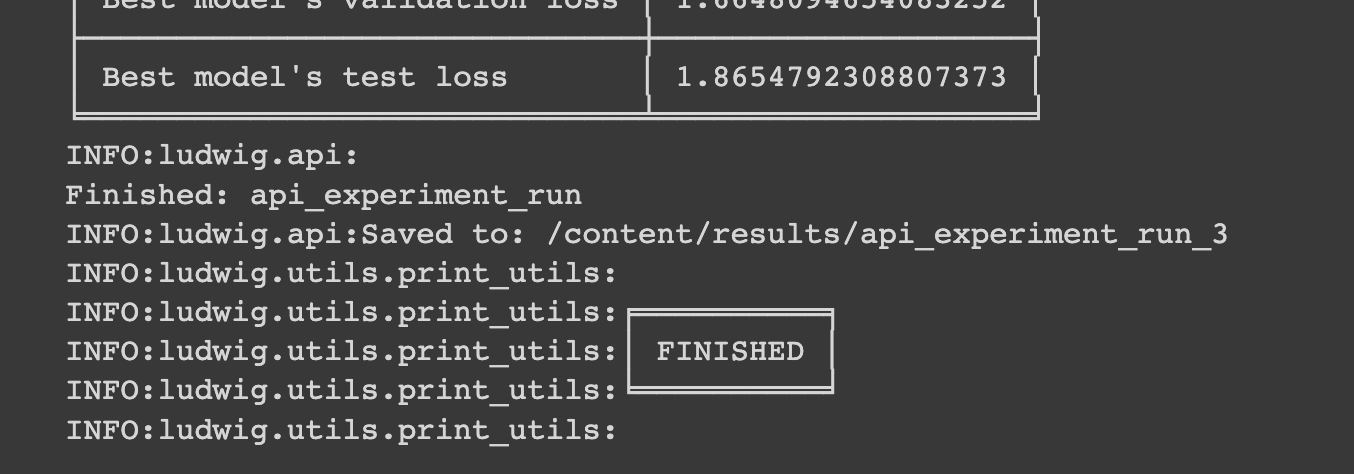

In [ ]:
!ludwig upload hf_hub --repo_id arnavgrg/ludwig-webinar --model_path /content/results/api_experiment_run_3


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-c

#### Want to try out our QLoRA fine-tuned weights that were fine-tuned on the entire dataset over 3 epochs? Check it out here on HuggingFace 🤗: https://huggingface.co/arnavgrg/codealpaca-qlora

```
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

config = PeftConfig.from_pretrained("arnavgrg/codealpaca-qlora")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf")
model = PeftModel.from_pretrained(model, "arnavgrg/codealpaca-qlora")
```

# **Resources** 🧺

- If you're new to LLMs, check out this webinar where Daliana Liu discusses the 10 things to know about LLMs: https://www.youtube.com/watch?v=fezMHMk7u5o&t=2027s&ab_channel=Predibase
- Ludwig 0.8 Release Blogpost for the full set of new features: https://predibase.com/blog/ludwig-v0-8-open-source-toolkit-to-build-and-fine-tune-custom-llms-on-your-data
- Ludwig Documentation: https://ludwig.ai/latest/

# **Try Predibase: The first low-code AI platform for developers**

If you're interested in a managed solution for training larger LLMs that require distributed training using multi-node multi-GPU setups, or for fast on-demand inference for LLMs, check out [Predibase](https://predibase.com/), the AI platform for engineers built on top of Ludwig! Try our free 14 day trial here by signing up [here](https://pbase.ai/3OD77wQ)

## How can Predibase help me with fine-tuning?
Here's a 6 minute read through of the challenges that fine-tuning poses, and how Predibase solves all of them for you. You can fine-tune Llama-2 with Scalable LLM infrastructure through Predibase: https://predibase.com/blog/how-to-fine-tune-llama-2-on-your-data-with-scalable-llm-infrastructure

### Check out these great blog posts and webinars on LLMs
1. Beyond Chat Use Cases for LLMs in Production: https://predibase.com/blog/beyond-chat-use-cases-for-llms-in-production
2. From Unstructured to Structured Data with Predibase: https://www.youtube.com/watch?v=KMZ_OSJ6bOE&t=523s&ab_channel=Predibase
3. Build your own LLM in less than 10 lines of code: https://www.youtube.com/watch?v=efMQgwM9dFY&ab_channel=Predibase